# Transformers con Keras

En este laboratorio, aprenderemos cómo usar la biblioteca **Keras** para construir un **transformer** utilizando una arquitectura **secuencia a secuencia (*sequence-to-sequence*) con autoatención** para traducción. Entrenaremos el modelo usando un **conjunto de datos de ejemplo** y luego utilizaremos este modelo para la **traducción de inglés a español**.


Objetivos de este cuaderno

Cómo usar la biblioteca Keras para construir un modelo transformer

Entrenar el modelo transformer utilizando un conjunto de datos dado

Usar el modelo transformer entrenado para realizar traducciones

## Importar las librerias necesarias

In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import warnings
warnings.simplefilter('ignore', FutureWarning)

C:\Users\Josue Santana Robled\PycharmProjects\Coursera\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Paso 1: Preparación de los datos

Comenzamos definiendo las oraciones y el texto para el entrenamiento de traducción.

Pares de oraciones:
Define un pequeño conjunto de datos de pares de oraciones inglés–español.

Secuencias objetivo:
Se antepone “startseq” y se añade “endseq” a cada oración objetivo para que el decodificador aprenda cuándo iniciar y cuándo detener la traducción.

In [2]:
# Sample parallel sentences (English -> Spanish)
input_texts = [
    "Hello.", "How are you?", "I am learning machine translation.", "What is your name?", "I love programming."
]
target_texts = [
    "Hola.", "¿Cómo estás?", "Estoy aprendiendo traducción automática.", "¿Cuál es tu nombre?", "Me encanta programar."
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]

A continuación, convertimos el texto de las oraciones en tokens y creamos un vocabulario

Tokenización:
Utiliza Tokenizer para convertir las palabras en secuencias numéricas.

In [4]:
# Tokenization
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

### Ahora rellenamos (padding) las oraciones correspondientes

Padding:
Garantiza que todas las secuencias tengan la misma longitud.

In [5]:
# Padding
max_input_length = max([len(seq) for seq in input_sequences])
max_output_length = max([len(seq) for seq in output_sequences])

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

In [6]:
# Prepare the target data for training
decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]

# Convert to one-hot
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

## Paso 2: Capa de Autoatención (Self-Attention)

La autoatención es un mecanismo que permite a un modelo enfocarse en las partes relevantes de la secuencia de entrada mientras procesa cada palabra. Esto es especialmente útil en:

Traducción automática (por ejemplo, alinear correctamente las palabras)

Resumen de texto

Reconocimiento de voz

Procesamiento de imágenes (Vision Transformers)

En esta implementación, la autoatención se utiliza para el modelado secuencia a secuencia basado en texto.

La autoatención funciona, para una secuencia de entrada dada, calculando una representación ponderada de todas las palabras para cada posición. Esto se logra mediante tres componentes clave:

1. Matrices de Consulta (Q), Clave (K) y Valor (V)

Para cada palabra (token) en una secuencia:

Consulta (Q): lo que esta palabra está buscando.

Clave (K): lo que esta palabra representa.

Valor (V): la información real contenida en la palabra.

2. Cálculo de las puntuaciones de atención

A continuación, calculamos la similitud entre cada consulta y cada clave usando atención por producto punto (dot-product attention).
Cada palabra en la secuencia presta atención a todas las demás palabras en función de estas puntuaciones.

3. Aplicación de escalado y softmax

Dado que los valores del producto punto pueden ser grandes, primero se escalan.
Después, al aplicar softmax, las puntuaciones se convierten en pesos de atención.

### Clase de Autoatención (Self-Attention)

En esta implementación de la capa de autoatención:

Inicialización de los pesos en el método build:

self.Wq, self.Wk, self.Wv son las matrices de pesos entrenables.

Su forma es (feature_dim, feature_dim), lo que significa que transforman las características de entrada en representaciones Q, K y V.

Aplicación de la atención usando el método call:
El método call():

Calcula Q, K y V multiplicando las entradas (salida del codificador/decodificador) por sus respectivas matrices de pesos.

Calcula las puntuaciones de atención por producto punto usando K.batch_dot(q, k, axes=[2, 2]), lo que produce una matriz de tamaño (batch_size, seq_len, seq_len).

Escala las puntuaciones para evitar valores grandes.

Aplica softmax para normalizar las puntuaciones de atención.

Multiplica los pesos de atención por V para obtener la salida final.

Método compute_output_shape:
Define la forma del tensor de salida después de que la capa procesa una entrada.

La forma de salida de la capa de autoatención permanece igual que la forma de entrada.

El mecanismo de atención transforma la entrada, pero no cambia sus dimensiones.

Si la capa de atención cambiara la forma, se debería modificar compute_output_shape.

In [7]:
# Define the Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

# Paso 3: Arquitectura del modelo

El modelo sigue una estructura Codificador–Decodificador (Encoder–Decoder):

Codificador (Encoder):

Recibe las oraciones de entrada (rellenadas y tokenizadas).

Utiliza una capa Embedding (representaciones de palabras) junto con una LSTM (para procesar secuencias).

Las LSTM se utilizan para ayudar a procesar oraciones de entrada de longitud variable y generar traducciones significativas.

Produce vectores de contexto (estados ocultos y de celda).

Capa de Atención

Se aplica tanto a las salidas del codificador como del decodificador.

Ayuda al decodificador a enfocarse en las palabras relevantes durante la traducción.

Decodificador (Decoder)

Recibe las secuencias objetivo (desplazadas un paso hacia adelante).

Utiliza una LSTM con los estados del codificador como estados iniciales.

Aplica autoatención para un mejor aprendizaje.

Usa una capa Dense (Softmax) para predecir la siguiente palabra.

In [8]:
from tensorflow.keras.layers import AdditiveAttention, Concatenate, Dense, Embedding, Input, LSTM
from tensorflow.keras.models import Model

# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention: decoder attends to encoder outputs
attention = AdditiveAttention()
attention_output = attention([decoder_outputs, encoder_outputs])

# Combine decoder outputs with attention context
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Final Dense layer
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 5, 256)    │      4,096 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 5, 256)    │      4,352 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 5, 256),  │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 5, 256),  │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 5, 256)    │        256 │ lstm_1[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 512)    │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 17)     │      8,721 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,068,049 (4.07 MB)

 Trainable params: 1,068,049 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

# Paso 4: Entrenamiento del modelo

Utiliza categorical_crossentropy como función de pérdida, ya que las palabras de salida están codificadas en one-hot.

Entrena el modelo utilizando el optimizador Adam durante 100 épocas.

In [9]:
# Step 6: Train the Model
history_glorot_adam = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0400 - loss: 2.8357
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4800 - loss: 2.8035
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3200 - loss: 2.7699
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3200 - loss: 2.7319
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3200 - loss: 2.6858
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3200 - loss: 2.6274
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2800 - loss: 2.5511
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2800 - loss: 2.4505
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2800 - loss: 2.3220
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2400 - loss: 2.1788
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2400 - loss: 2.0709
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2400 - loss

## Paso 5: Graficar la pérdida durante el entrenamiento


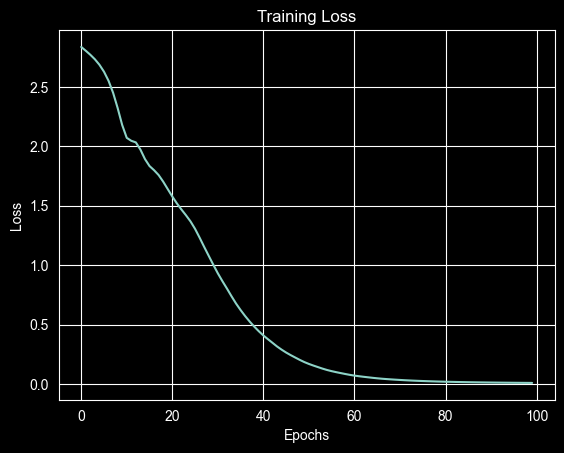

In [10]:
# Plotting training loss
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Practica Ejercicio 1

En este ejercicio práctico, entrenemos el modelo utilizando el inicializador he_uniform en lugar de glorot_uniform.
Luego, comparemos la pérdida de entrenamiento entre el modelo que usa glorot_uniform y el que usa he_uniform, graficándolas con matplotlib.

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1200 - loss: 2.8297
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3600 - loss: 2.7980
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3200 - loss: 2.7641
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3200 - loss: 2.7251
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3200 - loss: 2.6775
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3200 - loss: 2.6168
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2800 - loss: 2.5374
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2800 - loss: 2.4332
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2800 - loss: 2.3026
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2800 - loss: 2.1668
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2800 - loss: 2.0828
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2800 - loss

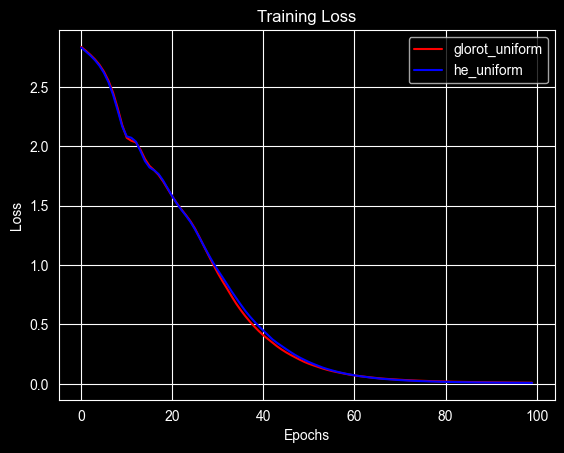

In [11]:
#Define the Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='he_uniform',
                                  trainable=True,
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='he_uniform',
                                  trainable=True,
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='he_uniform',
                                  trainable=True,
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape


#Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

#Decoder
decoder_inputs = Input(shape=(max_output_length - 1,), name="decoder_inputs")
decoder_embedding = Embedding(output_vocab_size, 256, name="decoder_embedding")(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

#Attention Mechanism
attention = AdditiveAttention(name="attention_layer")
attention_output = attention([decoder_outputs, encoder_outputs])

# Concatenate context with decoder outputs
decoder_concat = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, attention_output])

# Final Dense Layer
decoder_dense = Dense(output_vocab_size, activation='softmax', name="output_dense")
decoder_outputs = decoder_dense(decoder_concat)

#Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Step 6: Train the Model
history_he = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="glorot_uniform", color='red')
plt.plot(history_he.history['loss'], label="he_uniform", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Practica Ejercicio 2

En este ejercicio práctico, intenta usar el optimizador de gradiente adaptativo (Adagrad) en lugar de Adam.
Después, grafica y compara los resultados entre los optimizadores Adam y Adagrad.

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0076
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss

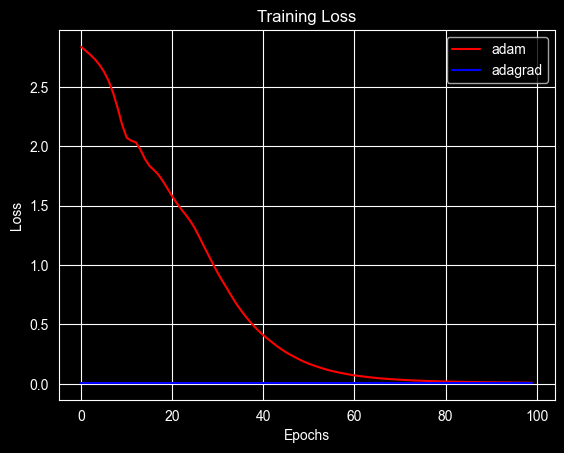

In [12]:
#Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])


#Step 6: Train the Model
history_adagrad = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="adam", color='red')
plt.plot(history_adagrad.history['loss'], label="adagrad", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()